In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import spatial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
from matplotlib import colors
from matplotlib import cm
import time
from sympy import *
import sympy as sym
from scipy.signal import find_peaks, peak_prominences
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import optimize
import pickle
from matplotlib.colors import ListedColormap
import matplotlib
import matplotlib as mpl

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.ticker as plticker

In [3]:
import funcs

In [4]:
flabel = 14
ftitle = 13
figpath = 'fig'

In [5]:
plt.rcParams["font.family"] = "Times"
plt.rcParams['mathtext.fontset'] = 'cm'

Define functions.

In [6]:
# conversion between Kd and m^2
def f_mag(Kd):
    Rm = 5    # in mm
    tm = 10    # in mm
    V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
    mu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
    
    mag_m = (2*Kd/mu0)**0.5*V    # magnet moment (A*m2)
    return mag_m**2

def f_Kd(magsqr):
    Rm = 5    # in mm
    tm = 10    # in mm
    V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
    mu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
    
    Kd = (magsqr**0.5/V)**2*mu0/2
    return Kd

In [7]:
Rm = 5    # in mm
tm = 10    # in mm
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2

# Kresling truss model without magnets

Initialization

In [8]:
n = 8       # n-sided polygons
R0 = 90     # in mm
w0 = [110,  35] # in mm, deg

In [9]:
# GLOBAL VARIABLES. DO NOT UPDATE!
num_pts = 2*n
num_edges = 2*n
h0 = w0[0] # in mm
theta1 = w0[1] # in degree, counter-clockwise

theta0 = w0[1]-180/n # in degree, counter-clockwise
phi_max = (180-180/n)-theta1
phi_min = -((180-180/n)+theta1)

# ks = 3.32/200       # element stiffness kN/m
ks = 0.02656
Kd = 0.8*1e6*0

Rm = 5    # in mm
tm = 10    # in mm
miu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
M = np.sqrt(2*Kd/miu0)    # magnetization (A/m)
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_m = M*V    # magnet moment (A*m2)

# initial config.
the = np.linspace(0,2*np.pi,n+1)
x = R0*np.cos(the)
y = R0*np.sin(the)
# lower layer
z1 = np.ones(len(x))*0
points1 = np.column_stack([x, y, z1])
points1 = points1[:-1]    # n x 3, fixed base pts
# upper layer
z2 = np.ones(len(x))*h0
points2 = np.column_stack([x, y, z2])
points2 = points2[:-1]    
points2 = funcs.rotation(theta0, points2) # n x 3
points_ref = np.vstack([points1, points2])
# connectivity, initial edge vec.
temp = np.array(range(n)) + np.ones(n)*n
connectivity_mountain = np.vstack([np.array(range(n)), temp])
connectivity_valley = np.vstack([np.array(range(n)), np.append(temp[1:], temp[0])])
connectivity = np.hstack([connectivity_mountain, connectivity_valley])
connectivity = connectivity.T
connectivity = connectivity.astype(int)
edge_vec0 = funcs.get_edge_vector(points_ref, connectivity)
adj = funcs.get_adj(connectivity)


# magnet moment direction vectors of lower and upper polygons
mag_arrange = np.array([[1, -1, 1, -1, 1, -1, 1, -1],
                    [-1, 1, -1, 1, -1, 1, -1, 1]]).flatten()  
mag_arrange = np.vstack([np.zeros(len(mag_arrange)), np.zeros(len(mag_arrange)), mag_arrange]).T
miu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
M = np.sqrt(2*Kd/miu0)    # magnetization (A/m)
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_m = M*V    # magnet moment (A*m2)
# magnet dipole positions
mag_points = points_ref.copy()

Define some variables for plotting.

In [10]:
points = points_ref
o_points = points_ref

w = [0, 0]

trian1 = np.vstack([np.array([0,0,0]), points[6], points[7]])
xs1, ys1, zs1 = trian1[:,0], trian1[:,1], trian1[:,2]

trian2 = np.vstack([np.array([0,0,h0]), points[14], points[15]])
xs2, ys2, zs2 = trian2[:,0], trian2[:,1], trian2[:,2]

mid67 = 0.5*(points[6]+points[7])
bisect = np.vstack([mid67, np.array([0,0,0])])
edgecounter = np.vstack([np.array([points[15,0], points[15,1], 0]), np.array([0,0,0])])
edgecounter0 = np.vstack([np.array([points[15,0], points[15,1], h0]), np.array([0,0,h0])])

ver1 = np.vstack([np.array([0,0,0]), np.array([0,0,h0])])
ver2 = np.vstack([np.array([points[15,0],points[15,1],0]), points[15]])

axisx = np.vstack([np.array([0,0,0]), np.array([30,0,0])])
axisy = np.vstack([np.array([0,0,0]), np.array([0,40,0])])
axisz = np.vstack([np.array([0,0,0]), np.array([0,0,h0])])
axisR = np.vstack([np.array([0,0,h0]), points[9]])

lex = (points[7] - points[6])
lex = lex/np.linalg.norm(lex)

ley = mid67 - np.array([0,0,0])
ley = -ley/np.linalg.norm(ley)

sx = 8
sy = 10

mid67_1 = mid67 + lex*sx
mid67_2 = mid67 + lex*sx + ley*sy
mid67_3 = mid67 + ley*sy
verfoot = np.vstack([mid67, mid67_1, mid67_2, mid67_3])

arc0 = 0.18*mid67
arc1 = 0.18*points[7]
arc2 = 0.18*np.array([points[15,0], points[15,1], 0])
arc = np.vstack([arc0, arc1, arc2])

hmid = 0.5*(points[5]+points[5])*1.2

vside1 = np.array([hmid[0], hmid[1], points[5,2]+h0])
vside2 = np.array([hmid[0], hmid[1], points[5,2]+h0+30])
vside = np.vstack([hmid, vside1])

eff1 = 1.1
eff2 = 1.3
vsideh1 = np.vstack([points[5]*eff1, points[5]*eff2])
hmid2 = np.array([points[5,0]*eff1, points[5,1]*eff1, h0])
hmid3 = np.array([points[5,0]*eff2, points[5,1]*eff2, h0])

vsideh2 = np.vstack([hmid2, hmid3])

<IPython.core.display.Javascript object>


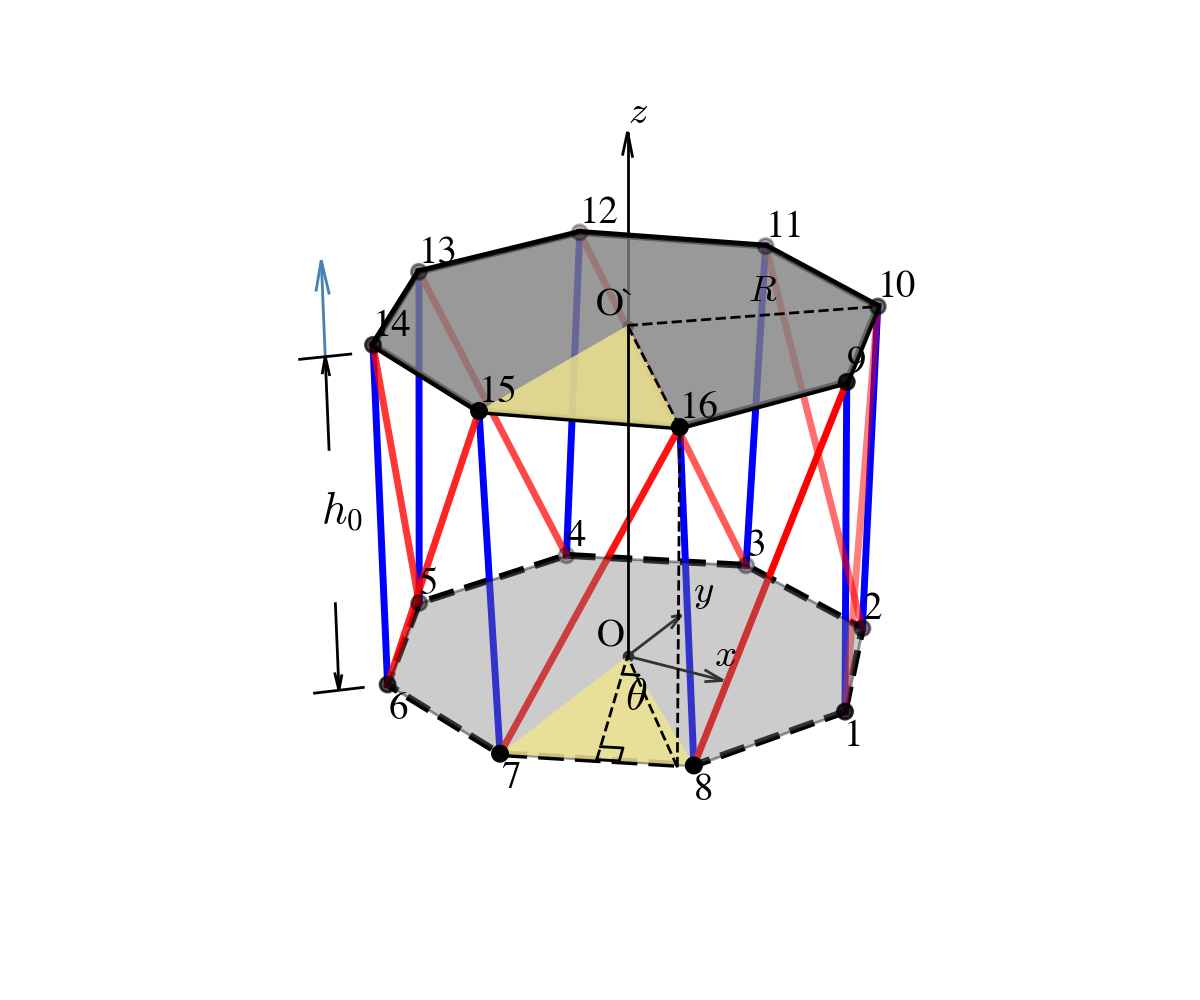

In [11]:
in_F=False
out_F=False
disp=True 
gap=5
offset=60 
arrow_coeff=20
grid=True
axis=True
tick=False

nsize = 14

phi = w[1]
u = w[0]
points = funcs.update_pts(o_points, w)
xs, ys, zs = points[:,0], points[:,1], points[:,2] 
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111, projection='3d')

verts1 = [list(zip(xs[:n], ys[:n], zs[:n]))]
ax.add_collection3d(Poly3DCollection(verts1, zorder=1, alpha = 0.4, color = 'gray', linewidth=1, edgecolor = 'k'))

plt.plot(np.hstack([xs[:n],xs[0]]), np.hstack([ys[:n],ys[0]]), np.hstack([zs[:n],zs[0]]), 
         '--', zorder=2, c='k',  linewidth=2.5)
plt.plot(np.hstack([xs[n:],xs[n]]), np.hstack([ys[n:],ys[n]]), np.hstack([zs[n:],zs[n]]), 
         c='k', zorder=3, linewidth=2.5)

#     a = np.linspace(0.5, 1, n)
for ii in range(n):
    this_edge = np.vstack([points[connectivity[ii][0]], points[connectivity[ii][1]]])
    plt.plot(this_edge[:,0], this_edge[:,1], this_edge[:,2], 'b', alpha=1.0, linewidth=2.5)
a = np.linspace(0.5, 1, n)
for ii in range(n,2*n):
    this_edge = np.vstack([points[connectivity[ii][0]], points[connectivity[ii][1]]])
    plt.plot(this_edge[:,0], this_edge[:,1], this_edge[:,2], 'r', alpha=a[ii-n], linewidth=2.5)

verts2 = [list(zip(xs[n:], ys[n:], zs[n:]))]
ax.add_collection3d(Poly3DCollection(verts2, zorder=2*n+4, alpha = 0.8, color = 'gray', 
                                     linewidth=1, edgecolor = 'k'))

trian1 = [list(zip(xs1, ys1, zs1))]
ax.add_collection3d(Poly3DCollection(trian1, zorder=2*n+5, alpha = 0.8, color = 'khaki', 
                                     linewidth=0, linestyle='--', edgecolor = 'k'))
trian2 = [list(zip(xs2, ys2, zs2))]
ax.add_collection3d(Poly3DCollection(trian2, zorder=2*n+6, alpha = 0.8, color = 'khaki', 
                                     linewidth=0, linestyle='--', edgecolor = 'k'))

plt.plot(edgecounter0[:,0], edgecounter0[:,1], edgecounter0[:,2], c='k', linewidth=1, 
         linestyle='--', zorder=2*n+7)
plt.plot(bisect[:,0], bisect[:,1], bisect[:,2], c='k', linewidth=1, 
         linestyle='--', zorder=2*n+7)
plt.plot(edgecounter[:,0], edgecounter[:,1], edgecounter[:,2], c='k', linewidth=1, 
         linestyle='--', zorder=2*n+8)
# plt.plot(ver1[:,0], ver1[:,1], ver1[:,2], c='k', linewidth=1, 
#          linestyle='--', zorder=2*n+7)
plt.plot(ver2[:,0], ver2[:,1], ver2[:,2], c='k', linewidth=1, 
         linestyle='--', zorder=2*n+7)
plt.plot(arc[:,0], arc[:,1], arc[:,2], c='k', linewidth=1, 
         linestyle='-', zorder=2*n+7)


plt.plot(axisz[:,0], axisz[:,1], axisz[:,2], c='k', linewidth=1, 
         linestyle='-', zorder=2*n)
plt.plot(axisR[:,0], axisR[:,1], axisR[:,2], c='k', linewidth=1, 
         linestyle='--', zorder=2*n)

plt.plot(verfoot[:,0], verfoot[:,1], verfoot[:,2], c='k', linewidth=1, zorder=2*n)
# plt.plot(vside[:,0], vside[:,1], vside[:,2], c='k', linewidth=1, zorder=2*n)
plt.plot(vsideh1[:,0], vsideh1[:,1], vsideh1[:,2], c='k', linewidth=1, zorder=2*n)
plt.plot(vsideh2[:,0], vsideh2[:,1], vsideh2[:,2], c='k', linewidth=1, zorder=2*n)

ax.quiver(0, 0, h0, # <-- starting point of vector
0, 0, 50+0.5*arrow_coeff, # <-- directions of vector
color = 'k', alpha = 1.0, lw = 1.0, arrow_length_ratio=0.13, zorder=2*n+8)
ax.quiver(0, 0, 0, # <-- starting point of vector
0, 30+0.5*arrow_coeff, 0, # <-- directions of vector
color = 'k', alpha = 1.0, lw = 1.0, arrow_length_ratio=0.2, zorder=2*n)
ax.quiver(0, 0, 0, # <-- starting point of vector
30+0.5*arrow_coeff, 0, 0, # <-- directions of vector
color = 'k', alpha = 1.0, lw = 1.0, arrow_length_ratio=0.2, zorder=2*n)
ax.quiver(vside1[0], vside1[1], vside1[2], # <-- starting point of vector
0,0,30, # <-- directions of vector
color = 'steelblue', alpha = 1.0, lw = 1.0, arrow_length_ratio=0.35, zorder=2*n)

ax.quiver(vside1[0], vside1[1], vside1[2]-30, # <-- starting point of vector
0,0,30, # <-- directions of vector
color = 'k', alpha = 1.0, lw = 1.0, arrow_length_ratio=0.2, zorder=2*n)
ax.quiver(hmid[0], hmid[1], hmid[2]+30, # <-- starting point of vector
0,0,-30, # <-- directions of vector
color = 'k', alpha = 1.0, lw = 1.0, arrow_length_ratio=0.2, zorder=2*n)

ax.scatter(xs[:n], ys[:n], zs[:n], zorder=2*n+5, c='k', s=30)
ax.scatter(xs[n:], ys[n:], zs[n:], zorder=2*n+6, c='k', s=30)
ax.scatter(0, 0, 0, zorder=2*n+7, c='k', s=10)
ax.scatter(0, 0, zs[-1], zorder=2*n+8, c='k', s=10)

for no in range(num_pts):
    if no==5 or no==6 or no==7 or no==0:
        ax.text(xs[no], ys[no], zs[no]-15, f'{no+1}', size=nsize, zorder=2*n+9+no, color='k', 
                horizontalalignment='left',
                verticalalignment='bottom') 
        
    else:
        ax.text(xs[no], ys[no], zs[no], f'{no+1}', size=nsize, zorder=2*n+9+no, color='k', 
                horizontalalignment='left',
                verticalalignment='bottom') 
ax.text(0-10, 0-5, 0,  'O', size=nsize, zorder=4*n+10, color='k', horizontalalignment='left',
            verticalalignment='bottom') 
ax.text(0-10, 0-5, zs[-1],  "O`", size=nsize, zorder=4*n+11, color='k', horizontalalignment='left',
            verticalalignment='bottom') 
ax.text(0, 0, h0+60,  "$z$", size=nsize, zorder=4*n+11, color='k', horizontalalignment='left',
            verticalalignment='bottom') 
ax.text(0+2, 40+5, 0,  "$y$", size=nsize, zorder=4*n+11, color='k', horizontalalignment='left',
            verticalalignment='bottom') 
ax.text(30+5, 0+2, 0,  "$x$", size=nsize, zorder=4*n+11, color='k', horizontalalignment='left',
            verticalalignment='bottom') 

markR0 = 0.5*(np.array([0,0,h0])+points[9])
ax.text(markR0[0]-5, markR0[1]+5, markR0[2], "$R$", size=nsize-1, zorder=4*n+11, 
        color='k', horizontalalignment='left',
            verticalalignment='bottom') 
eff = 0.5
ax.text(eff*points[7,0]-7, eff*points[7,1]-13, eff*points[7,2], '$\\theta$', 
        size=nsize+2, zorder=4*n+11, color='k', horizontalalignment='left',
            verticalalignment='bottom') 

h0mark = 0.5*(vside1+hmid)
ax.text(h0mark[0]-15, h0mark[1]+15, h0mark[2]-10,  '$h_0$', size=nsize+2, zorder=4*n+11, color='k',
        horizontalalignment='left', verticalalignment='bottom') 
# ax.text(vside2[0], vside2[1], vside2[2],  '$u$', size=nsize+2, zorder=4*n+11, color='k',
#         horizontalalignment='left', verticalalignment='bottom') 

loc = plticker.MultipleLocator(base=40.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)

# if h0>100:
#     ax.zaxis.set_major_locator(loc)

ax.set_xlim(-R0, R0)
ax.set_ylim(-R0, R0)
ax.set_zlim(-gap, h0+gap)

#     if axis:
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
# Hide grid lines

ax.grid(False)

plt.axis('off')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

#     plt.tight_layout()
plt.show()
plt.savefig(f'{figpath}/Kresling_truss.png', dpi = 300)

<IPython.core.display.Javascript object>


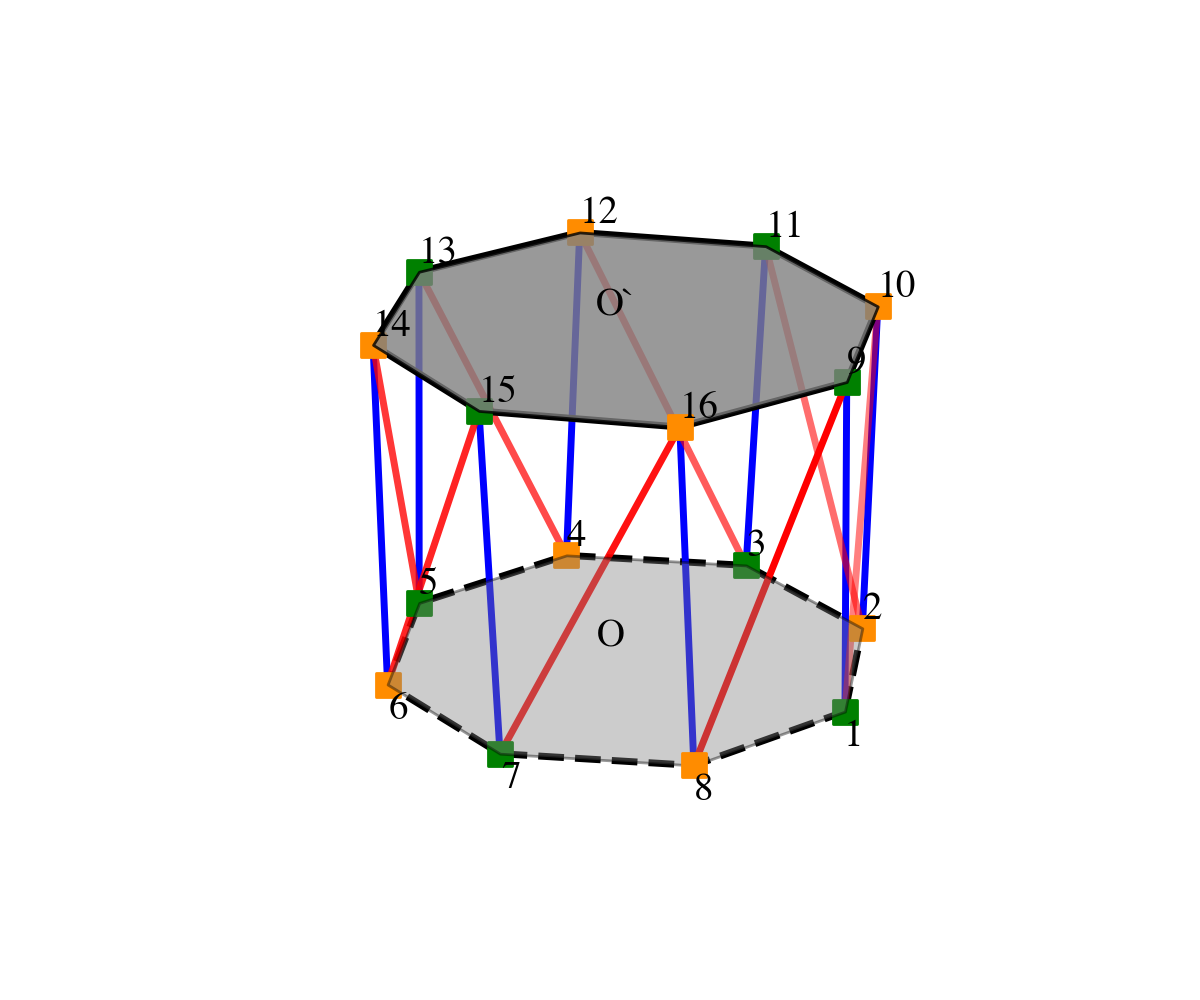

In [12]:
in_F=False
out_F=False
disp=True 
gap=5
offset=60 
arrow_coeff=20
grid=True
axis=True
tick=False

nsize = 14

phi = w[1]
u = w[0]
points = funcs.update_pts(o_points, w)
xs, ys, zs = points[:,0], points[:,1], points[:,2] 
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111, projection='3d')



verts1 = [list(zip(xs[:n], ys[:n], zs[:n]))]
ax.add_collection3d(Poly3DCollection(verts1, zorder=1, alpha = 0.4, color = 'gray', linewidth=1, edgecolor = 'k'))

plt.plot(np.hstack([xs[:n],xs[0]]), np.hstack([ys[:n],ys[0]]), np.hstack([zs[:n],zs[0]]), 
         '--', zorder=2, c='k',  linewidth=2.5)
plt.plot(np.hstack([xs[n:],xs[n]]), np.hstack([ys[n:],ys[n]]), np.hstack([zs[n:],zs[n]]), 
         c='k', zorder=3, linewidth=2.5)

#     a = np.linspace(0.5, 1, n)
for ii in range(n):
    this_edge = np.vstack([points[connectivity[ii][0]], points[connectivity[ii][1]]])
    plt.plot(this_edge[:,0], this_edge[:,1], this_edge[:,2], 'b', alpha=1.0, linewidth=2.5)
a = np.linspace(0.5, 1, n)
for ii in range(n,2*n):
    this_edge = np.vstack([points[connectivity[ii][0]], points[connectivity[ii][1]]])
    plt.plot(this_edge[:,0], this_edge[:,1], this_edge[:,2], 'r', alpha=a[ii-n], linewidth=2.5)

verts2 = [list(zip(xs[n:], ys[n:], zs[n:]))]
ax.add_collection3d(Poly3DCollection(verts2, zorder=2*n+4, alpha = 0.8, color = 'gray', 
                                     linewidth=1, edgecolor = 'k'))

cc = [ 'g',"darkorange"]*n
for  ii in range(len(xs)):
    ax.scatter(xs[ii], ys[ii], zs[ii], zorder=2*n+5+ii, c=cc[ii], marker='s', s=80)

for no in range(num_pts):
    if no==5 or no==6 or no==7 or no==0:
        ax.text(xs[no], ys[no], zs[no]-15, f'{no+1}', size=nsize, zorder=2*n+9+no, color='k', 
                horizontalalignment='left',
                verticalalignment='bottom') 
        
    else:
        ax.text(xs[no], ys[no], zs[no], f'{no+1}', size=nsize, zorder=2*n+9+no, color='k', 
                horizontalalignment='left',
                verticalalignment='bottom') 
ax.text(0-10, 0-5, 0,  'O', size=nsize, zorder=4*n+10, color='k', horizontalalignment='left',
            verticalalignment='bottom') 
ax.text(0-10, 0-5, zs[-1],  "O`", size=nsize, zorder=4*n+11, color='k', horizontalalignment='left',
            verticalalignment='bottom') 

loc = plticker.MultipleLocator(base=40.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.set_xlim(-R0, R0)
ax.set_ylim(-R0, R0)
ax.set_zlim(-gap, h0+gap)
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
ax.grid(False)
plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()
plt.savefig(f'{figpath}/nodes.png', dpi = 300)

### Deformation energy landscape of a mono-stable Kresling truss model

In [13]:
n = 8
R0 = 90
w0 = [90.36734693877551, 30.612244897959183] # in mm, deg

h0 = w0[0] # in mm
theta1 = w0[1]/180*np.pi # degree to rad, counter-clockwise

ks = 0.02656
Kd = 0.8*1e6*0
Rm = 5    # in mm
tm = 10    # in mm
miu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
M = np.sqrt(2*Kd/miu0)    # magnetization (A/m)
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_m = M*V    # magnet moment (A*m2)
# magnet moment direction vectors of lower and upper polygons
mag_arrange = np.array([[1, -1, 1, -1, 1, -1, 1, -1],
                    [-1, 1, -1, 1, -1, 1, -1, 1]]).flatten()  
mag_arrange = np.vstack([np.zeros(len(mag_arrange)), np.zeros(len(mag_arrange)), mag_arrange]).T

In [14]:
KT1 = funcs.create_KTgeometry(n, R0, h0, theta1, ks, mag_m, mag_arrange)

In [15]:
# mesh grid
N = 400     #
maxdown = -0.80
maxup = 0.4
h0 = KT1['h0']
theta1 = KT1['theta1']
phi_min = KT1['phi_min']
phi_max = KT1['phi_max']

XX, YY = np.mgrid[maxdown*h0:maxup*h0:complex(0, N), phi_min: phi_max:complex(0, N)]

# force and total energy calc
Zforce_tot = funcs.total_Zforce_parallel(KT1, XX, YY, N, N)
torque_tot = funcs.total_torque_parallel(KT1, XX, YY, N, N)
ZZ_tot = funcs.total_potential_parallel(KT1, XX, YY, N, N, norm=True)

In [16]:
bbb = (ZZ_tot.T).copy()
bbb[np.where(bbb>0.25)] = None

<IPython.core.display.Javascript object>


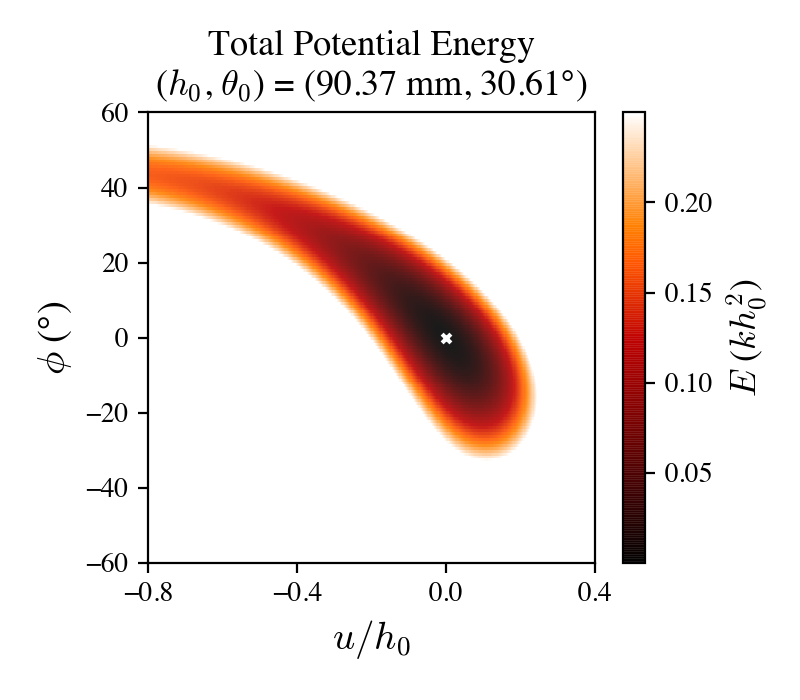

In [17]:
fig1 = plt.figure(figsize=[4,3.5])
ax1 = fig1.add_subplot(111)
plt.imshow(np.flipud((bbb)), extent=[maxdown, maxup, phi_min/np.pi*180, phi_max/np.pi*180], aspect="auto", alpha=0.9, 
           cmap=plt.cm.gist_heat)
cbar = plt.colorbar(format='%.2f')
cbar.set_label('$E$ ($kh_0^2$)', size=flabel-1)
ax1.set_ylabel('$\phi$ (\u00b0)', fontsize=flabel)
ax1.set_xlabel('$u/h_0$', fontsize=flabel)
plt.xticks([-0.8, -0.4, 0, 0.4])
plt.scatter([0], [0], marker='x', color='white', s=10)
ax1.set_title(f'Total Potential Energy\n($h_0$, $\\theta_0$) = ({h0:.2f} mm, {theta1/np.pi*180:.2f}\u00b0)', 
              fontsize=ftitle)
plt.ylim(-60,60)
plt.xlim(maxdown, maxup)
plt.tight_layout()
plt.savefig(f'{figpath}/monoKT.png', dpi = 300)
plt.show()

### Deformation energy landscape of a bi-stable Kresling truss model (compact)

In [18]:
P1 = 50
P2 = 50
ratio_set = np.linspace(0.8,1.8,P1)
angle_set = np.linspace(0,100,P2)
ratio_set , angle_set = np.meshgrid(ratio_set , angle_set)
config_set = [[i, j] for i,j in zip((ratio_set*R0).flatten(), angle_set.flatten())]

In [19]:
n=8
Kd = 0
w0 = config_set[1628]
h0 = w0[0] # in mm
theta1 = w0[1]/180*np.pi # in degree, counter-clockwise

ks = 1.0
# magnet moment direction vectors of lower and upper polygons
mag_arrange = np.array([[1, -1, 1, -1, 1, -1, 1, -1],
                    [-1, 1, -1, 1, -1, 1, -1, 1]]).flatten()  
mag_arrange = np.vstack([np.zeros(len(mag_arrange)), np.zeros(len(mag_arrange)), mag_arrange]).T
miu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
M = np.sqrt(2*Kd/miu0)    # magnetization (A/m)
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_m = M*V    # magnet moment (A*m2)

KT2 = funcs.create_KTgeometry(n, R0, h0, theta1, ks, mag_m, mag_arrange)

In [20]:
# mesh grid
N = 400     #
maxdown = -0.80
maxup = 0.4
h0 = KT2['h0']
theta1 = KT2['theta1']
phi_min = KT2['phi_min']
phi_max = KT2['phi_max']

XX, YY = np.mgrid[maxdown*h0:maxup*h0:complex(0, N), phi_min: phi_max:complex(0, N)]

# force and total energy calc
Zforce_tot = funcs.total_Zforce_parallel(KT2, XX, YY, N, N)
torque_tot = funcs.total_torque_parallel(KT2, XX, YY, N, N)
ZZ_tot = funcs.total_potential_parallel(KT2, XX, YY, N, N, norm=True)

In [21]:
bbb = (ZZ_tot.T).copy()
bbb[np.where(bbb>0.1)] = None

<IPython.core.display.Javascript object>


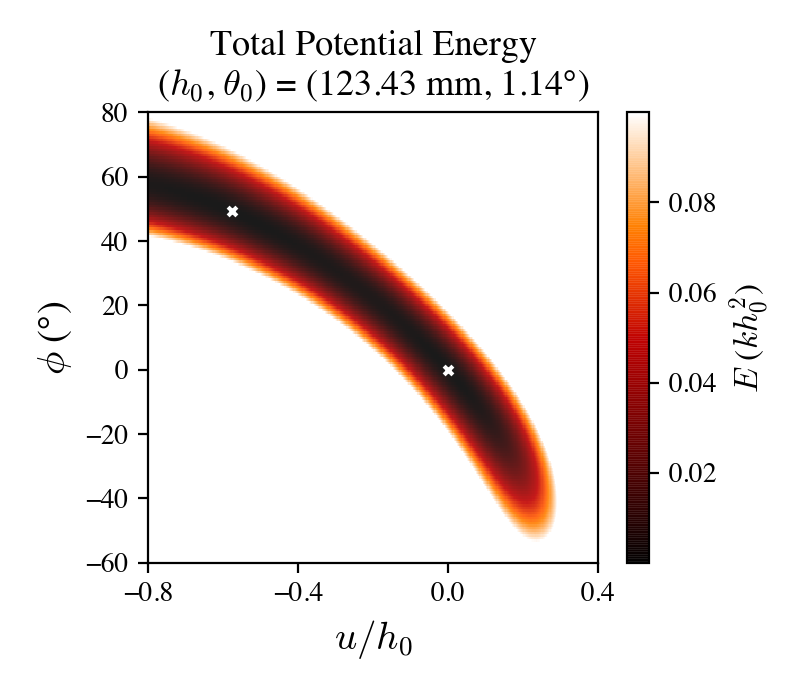

In [22]:
fig1 = plt.figure(figsize=[4,3.5])
ax1 = fig1.add_subplot(111)
plt.imshow(np.flipud((bbb)), extent=[maxdown, maxup, phi_min/np.pi*180, phi_max/np.pi*180], aspect="auto", alpha=0.9, 
           cmap=plt.cm.gist_heat)
cbar = plt.colorbar(format='%.2f')
cbar.set_label('$E$ ($kh_0^2$)', size=flabel-2)

ax1.set_ylabel('$\phi$ (\u00b0)', fontsize=flabel)
ax1.set_xlabel('$u/h_0$', fontsize=flabel)
plt.xticks([-0.8, -0.4, 0, 0.4])
plt.scatter([0,-7.11867e+01/h0], [0,4.93877e+01], marker='x', color='white', s=10)
ax1.set_title(f'Total Potential Energy\n($h_0$, $\\theta_0$) = ({h0:.2f} mm, {theta1:.2f}\u00b0)', 
              fontsize=ftitle)
plt.ylim(-60,80)
plt.xlim(maxdown, maxup)
plt.tight_layout()
plt.savefig(f'{figpath}/biKT_compress.png', dpi = 300)
plt.show()

### Deformation energy landscape of a bi-stable Kresling truss model (expand)

In [23]:
n=8
Kd = 0
w0 = [95.878, 100]
h0 = w0[0] # in mm
theta1 = w0[1]/180*np.pi # in degree, counter-clockwise

ks = 1.0
# magnet moment direction vectors of lower and upper polygons
mag_arrange = np.array([[1, -1, 1, -1, 1, -1, 1, -1],
                    [-1, 1, -1, 1, -1, 1, -1, 1]]).flatten()  
mag_arrange = np.vstack([np.zeros(len(mag_arrange)), np.zeros(len(mag_arrange)), mag_arrange]).T
miu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
M = np.sqrt(2*Kd/miu0)    # magnetization (A/m)
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_m = M*V    # magnet moment (A*m2)

KT3 = funcs.create_KTgeometry(n, R0, h0, theta1, ks, mag_m, mag_arrange)

In [24]:
# mesh grid
N = 400     #
maxdown = -0.80
maxup = 0.4
h0 = KT3['h0']
theta1 = KT3['theta1']
phi_min = KT3['phi_min']
phi_max = KT3['phi_max']

XX, YY = np.mgrid[maxdown*h0:maxup*h0:complex(0, N), phi_min: phi_max:complex(0, N)]

# force and total energy calc
Zforce_tot = funcs.total_Zforce_parallel(KT3, XX, YY, N, N)
torque_tot = funcs.total_torque_parallel(KT3, XX, YY, N, N)
ZZ_tot = funcs.total_potential_parallel(KT3, XX, YY, N, N, norm=True)

In [25]:
bbb = (ZZ_tot.T).copy()
bbb[np.where(bbb>0.10)] = None

<IPython.core.display.Javascript object>


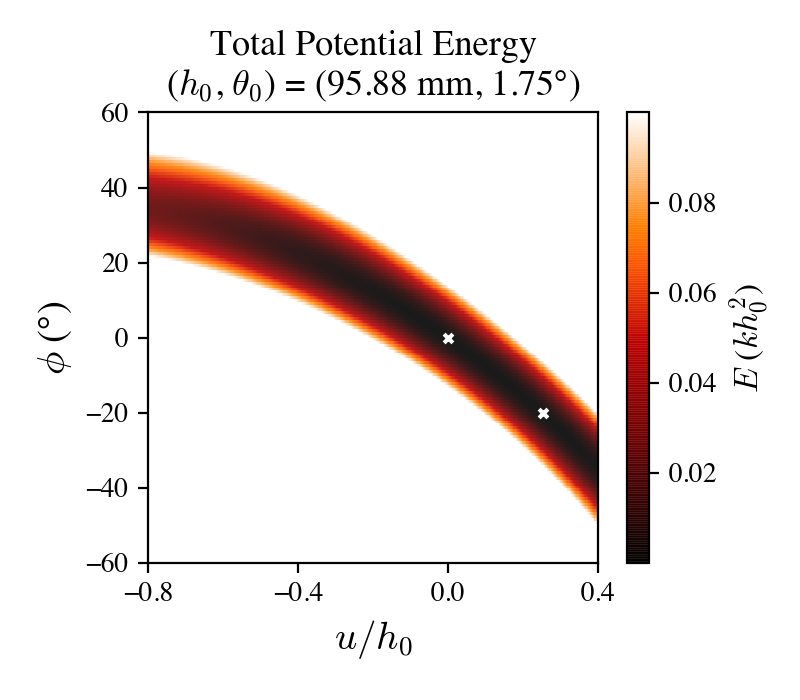

In [26]:
fig1 = plt.figure(figsize=[4,3.5])
ax1 = fig1.add_subplot(111)
plt.imshow(np.flipud((bbb)), extent=[maxdown, maxup, phi_min/np.pi*180, phi_max/np.pi*180], aspect="auto", alpha=0.9, 
           cmap=plt.cm.gist_heat)
cbar = plt.colorbar(format='%.2f')
cbar.set_label('$E$ ($kh_0^2$)', size=flabel-2)

# plt.scatter(found_pt[:,0]/h0, found_pt[:,1], s=15, c='w', marker='x')

ax1.set_ylabel('$\phi$ (\u00b0)', fontsize=flabel)
ax1.set_xlabel('$u/h_0$', fontsize=flabel)
plt.xticks([-0.8, -0.4, 0, 0.4])
plt.scatter([0,24.08/h0], [0,-2.00000e+01], marker='x', color='white', s=10)
ax1.set_title(f'Total Potential Energy\n($h_0$, $\\theta_0$) = ({h0:.2f} mm, {theta1:.2f}\u00b0)', 
              fontsize=ftitle)
plt.ylim(-60, 60)
plt.xlim(maxdown, maxup)
plt.tight_layout()
plt.savefig(f'{figpath}/biKT_expand.png', dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


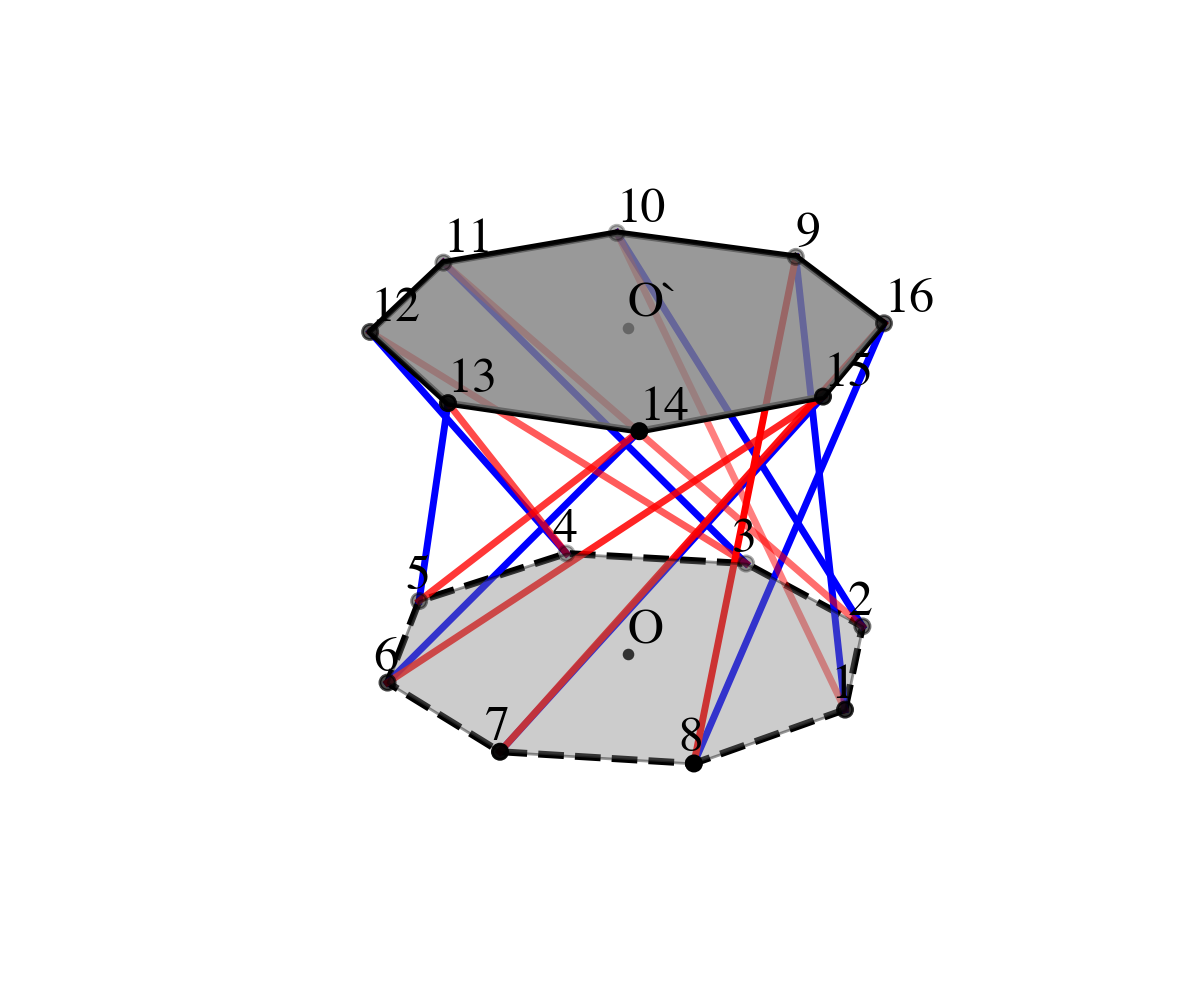

In [27]:
funcs.plot_TCO(KT3, [0,0], in_F=False, out_F=False, nsize=18, xoff=-5, yoff=-2,
         disp=False, gap=5, offset=60, grid=False, axis=False, tick=False)

<IPython.core.display.Javascript object>


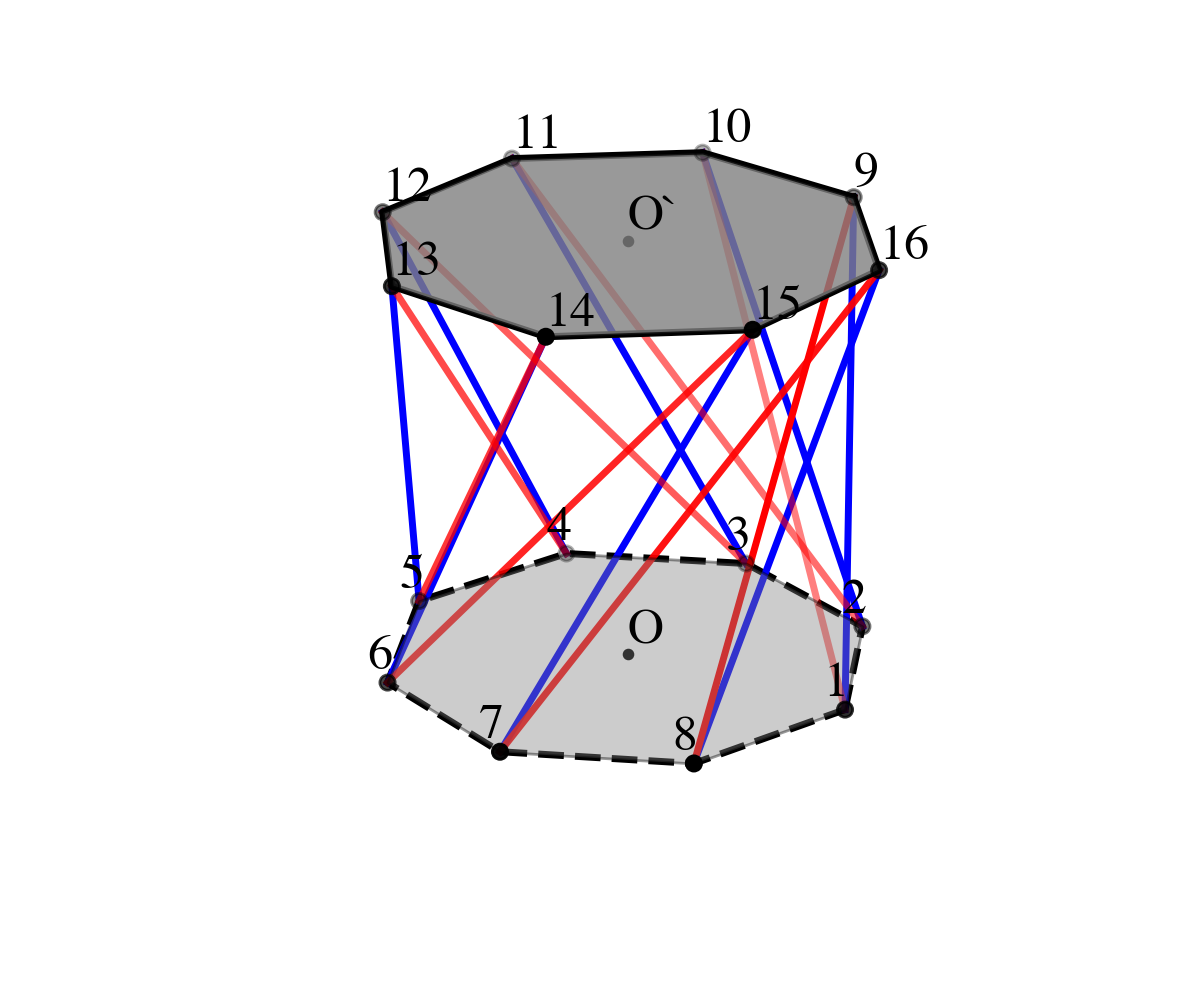

In [28]:
funcs.plot_TCO(KT3, [24.08, -2.00000e+01/180*np.pi], in_F=False, out_F=False, nsize=18,
         disp=False, gap=5, offset=60, grid=False, axis=False, tick=False,  xoff=-7.5, yoff=-2)

# Magneto-Kresling truss model

In [29]:
n = 8      # n-sided polygons
R0 = 90     # in mm
Kd = 1e2*10**6/200     # magnetization in J/m3
w0 = [72, 35]

h0 = w0[0] # in mm
theta1 = w0[1]/180*np.pi # in degree, counter-clockwise

ks = 1.0
# magnet moment direction vectors of lower and upper polygons
mag_arrange = np.array([[1, -1, 1, -1, 1, -1, 1, -1],
                    [-1, 1, -1, 1, -1, 1, -1, 1]]).flatten()  
mag_arrange = np.vstack([np.zeros(len(mag_arrange)), np.zeros(len(mag_arrange)), mag_arrange]).T
miu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
M = np.sqrt(2*Kd/miu0)    # magnetization (A/m)
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_m = M*V    # magnet moment (A*m2)

KT4 = funcs.create_KTgeometry(n, R0, h0, theta1, ks, mag_m, mag_arrange)

<IPython.core.display.Javascript object>


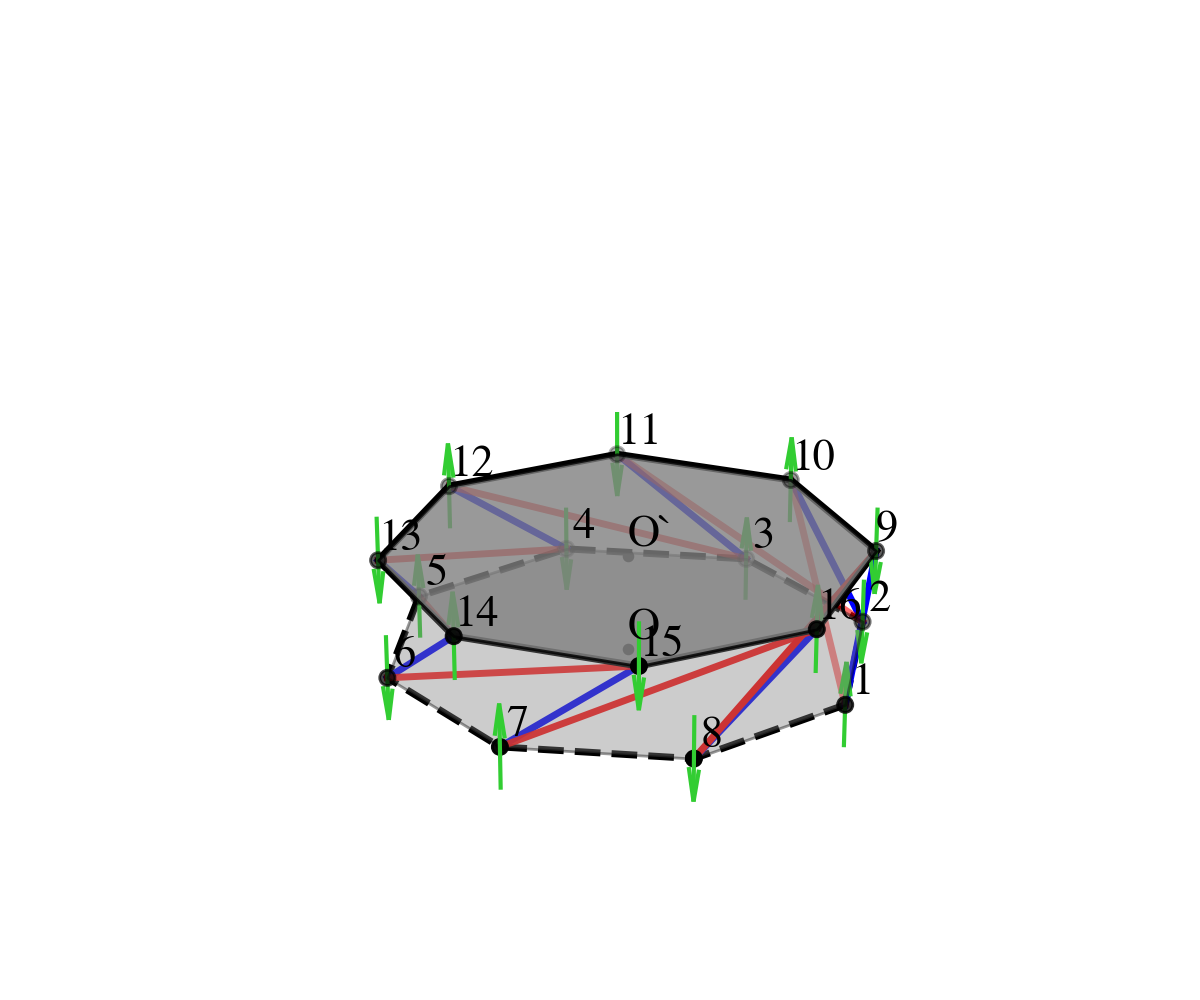

In [30]:
funcs.plot_TCO(KT4, [-50,20/180*np.pi], in_F=False, out_F=False, 
         disp=False, gap=5, offset=60, grid=False, axis=False, tick=False, xoff=1.5, yoff=2)

## A bi-stable magneto- and nonmagneto- Kresling truss

In [31]:
n = 8
w0 = [145.46938775510202, 53.06122448979592]
R0 = 90

w/ mag

In [32]:
h0 = w0[0] # in mm
theta1 = w0[1]/180*np.pi # in rad, counter-clockwise

ks = 0.02656
Kd = 0.8*1e6

# magnet moment direction vectors of lower and upper polygons
tempa = np.repeat(np.array([[1],[-1]]), n//2 ,axis=1).T.flatten()
tempb = np.repeat(np.array([[-1],[1]]), n//2 ,axis=1).T.flatten()
mag_arrange = np.hstack([tempa, tempb]) 
mag_arrange = np.vstack([np.zeros(len(mag_arrange)), np.zeros(len(mag_arrange)), mag_arrange]).T
miu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
M = np.sqrt(2*Kd/miu0)    # magnetization (A/m)
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_m = M*V    # magnet moment (A*m2)

KT5 = funcs.create_KTgeometry(n, R0, h0, theta1, ks, mag_m, mag_arrange)

In [33]:
# path1 T=0
uset_tot4, phi_set4, U_minset_tot4, err4 = funcs.find_T0_path(KT5, -0.23/KT5['h0'], -0.7, spacing=-0.01, startphi=-5/180*np.pi, endphi=KT5['phi_max'])

In [34]:
# mesh grid
N = 400     #
maxdown = -0.70
maxup = 0.05
h0 = KT5['h0']
theta1 = KT5['theta1']
phi_min = KT5['phi_min']
phi_max = KT5['phi_max']

XX, YY = np.mgrid[maxdown*h0:maxup*h0:complex(0, N), phi_min: phi_max:complex(0, N)]

# force and total energy calc
Zforce_tot = funcs.total_Zforce_parallel(KT5, XX, YY, N, N)
torque_tot = funcs.total_torque_parallel(KT5, XX, YY, N, N)
ZZ_tot = funcs.total_potential_parallel(KT5, XX, YY, N, N, norm=True)

w/o mag


In [35]:
# GLOBAL VARIABLES. DO NOT UPDATE!
num_pts = 2*n
num_edges = 2*n
h0 = w0[0] # in mm
theta1 = w0[1]/180*np.pi # in rad, counter-clockwise

ks = 0.02656
Kd = 0.8*1e6*0

# magnet moment direction vectors of lower and upper polygons
tempa = np.repeat(np.array([[1],[-1]]), n//2 ,axis=1).T.flatten()
tempb = np.repeat(np.array([[-1],[1]]), n//2 ,axis=1).T.flatten()
mag_arrange = np.hstack([tempa, tempb])  
mag_arrange = np.vstack([np.zeros(len(mag_arrange)), np.zeros(len(mag_arrange)), mag_arrange]).T
miu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
M = np.sqrt(2*Kd/miu0)    # magnetization (A/m)
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_m = M*V    # magnet moment (A*m2)

KT6 = funcs.create_KTgeometry(n, R0, h0, theta1, ks, mag_m, mag_arrange)

In [36]:
# path2
uset_tot5, phi_set5, U_minset_tot5, err5 = funcs.find_T0_path(KT6, 0, -0.7, startphi=0, endphi=KT6['phi_max'], spacing=-0.01)

In [37]:
# mesh grid
N = 400     #
maxdown = -0.70
maxup = 0.05
h0 = KT6['h0']
theta1 = KT6['theta1']
phi_min = KT6['phi_min']
phi_max = KT6['phi_max']

XX, YY = np.mgrid[maxdown*h0:maxup*h0:complex(0, N), phi_min: phi_max:complex(0, N)]

# force and total energy calc
Zforce_tot2 = funcs.total_Zforce_parallel(KT6, XX, YY, N, N)
torque_tot2 = funcs.total_torque_parallel(KT6, XX, YY, N, N)
ZZ_tot2 = funcs.total_potential_parallel(KT6, XX, YY, N, N, norm=True)

plot

In [38]:
pts_w = np.array([ [-0.23,0.33,-0.000065], [-62.41, 58.67, 0.004714]])
pts_wo = np.array([[0,0,0], [-89.15, 73.88, 0]]) 

In [39]:
aaa = (ZZ_tot2.T).copy()
thre = 0.025
aaa[np.where(aaa>thre)] = None
bbb = (ZZ_tot.T).copy()
bbb[np.where(bbb>thre)] = None

<IPython.core.display.Javascript object>


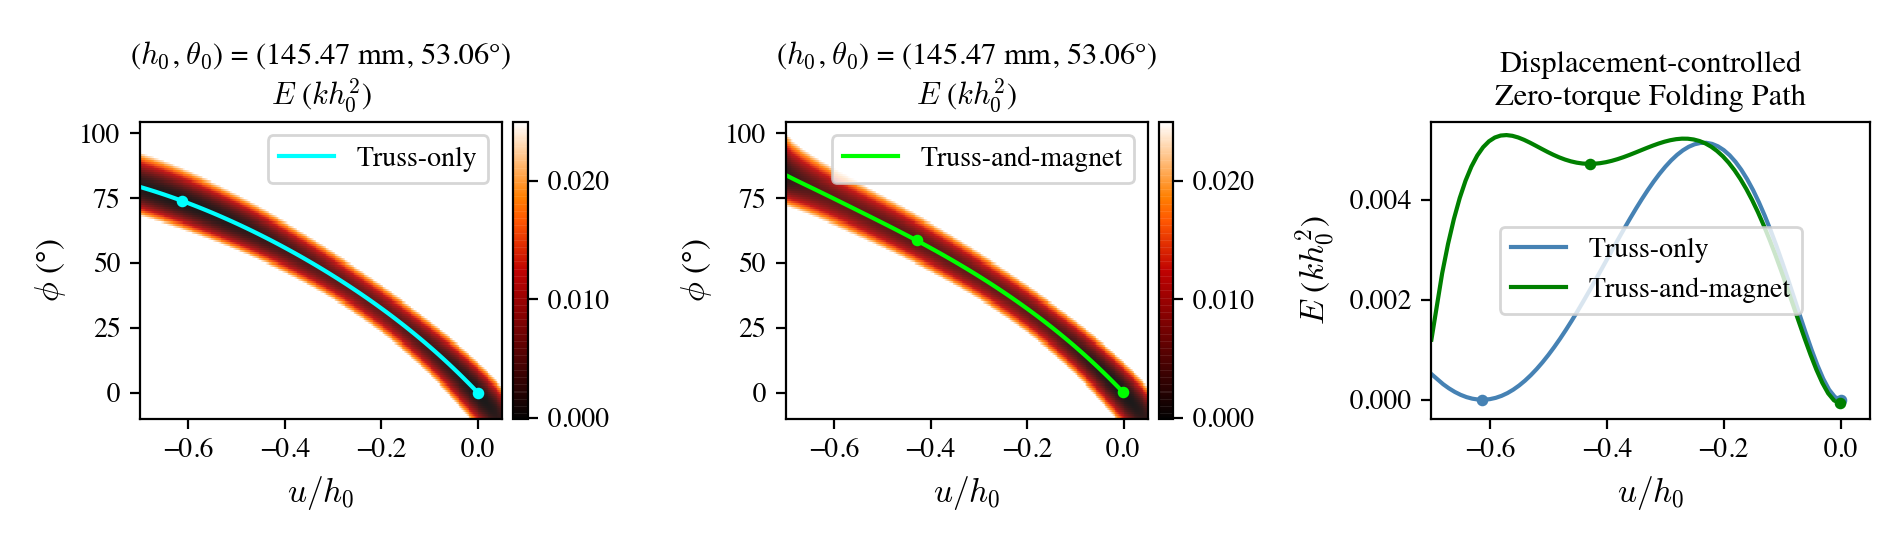

In [40]:
fig = plt.figure(figsize=[9.5, 2.75])

ax1 = fig.add_subplot(131)
plt.imshow(np.flipud((aaa)), extent=[maxdown, maxup, KT5['phi_min']*180/np.pi, KT5['phi_max']*180/np.pi], aspect="auto", alpha=0.9, 
           cmap=plt.cm.gist_heat)
plt.colorbar(format='%.3f', orientation="vertical", pad = 0.025)
plt.clim(np.min([ZZ_tot2, ZZ_tot]), thre)
plt.plot(uset_tot5/h0, phi_set5*180/np.pi, '-', c='cyan', linewidth=1.5, label='Truss-only')
plt.scatter(pts_wo[:,0]/h0, pts_wo[:,1], s=10, c='cyan', marker='o', zorder=11)
ax1.set_ylabel('$\phi$ (\u00b0)', fontsize=flabel-2)
ax1.set_xlabel('$u/h_0$', fontsize=flabel-2)
plt.xticks([-0.6, -0.4, -0.2, 0])
plt.legend(loc='upper right')
ax1.set_title(f'($h_0$, $\\theta_0$) = (145.47 mm, 53.06\u00b0)\n$E$ ($kh_0^2$)', fontsize=ftitle-2)
plt.ylim(-10, )
plt.xlim(maxdown, 0.05)


ax2= fig.add_subplot(132)
plt.imshow(np.flipud((bbb)), extent=[maxdown, maxup, KT5['phi_min']*180/np.pi, KT5['phi_max']*180/np.pi], aspect="auto", alpha=0.9, 
           cmap=plt.cm.gist_heat)
plt.colorbar(format='%.3f', orientation="vertical", pad = 0.025)
plt.clim(np.min([ZZ_tot2, ZZ_tot]), thre)

plt.plot(uset_tot4/h0, phi_set4*180/np.pi, '-', c='lime', linewidth=1.5, label='Truss-and-magnet')
plt.scatter(pts_w[:,0]/h0, pts_w[:,1], s=10, c='lime', marker='o', zorder=11)
plt.legend(loc='upper right')

ax2.set_ylabel('$\phi$ (\u00b0)', fontsize=flabel-2)
ax2.set_xlabel('$u/h_0$', fontsize=flabel-2)
plt.xticks([-0.6, -0.4, -0.2, 0])
ax2.set_title(f'($h_0$, $\\theta_0$) = (145.47 mm, 53.06\u00b0)\n$E$ ($kh_0^2$)', fontsize=ftitle-2)
plt.ylim(-10,)
plt.xlim(maxdown, 0.05)


ax3= fig.add_subplot(133)
plt.plot(uset_tot5/h0, U_minset_tot5, '-', c='steelblue', linewidth=1.5, label='Truss-only')
plt.plot(uset_tot4/h0, U_minset_tot4, '-', c='green', linewidth=1.5, label='Truss-and-magnet')
plt.ylabel('$E$ ($kh^2_0$)', fontsize=flabel-2)
plt.xlim(maxdown, 0.05)
plt.xticks([-0.6, -0.4, -0.2, 0])
plt.legend(loc='center')
plt.scatter(pts_wo[:,0]/h0, pts_wo[:,2], s=10, c='steelblue', zorder=10)
plt.scatter(pts_w[:,0]/h0, pts_w[:,2], s=10, c='green', zorder=11)

ax3.set_xlabel('$u/h_0$' , fontsize=flabel-2)
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.title(f'Displacement-controlled\nZero-torque Folding Path', fontsize=ftitle-2)

plt.tight_layout()
plt.show()

## A tri-stable magneto-Kresling truss

In [41]:
n = 8
factor = 1
w0 = [107.794937*factor,  29.655172]

In [42]:
R0 = 90*factor
h0 = w0[0] # in mm
theta1 = w0[1]/180*np.pi # in rad, counter-clockwise

ks = 0.02656
Kd = 0.8*1e6

# magnet moment direction vectors of lower and upper polygons
mag_arrange = np.array([[1, -1, 1, -1, 1, -1, 1, -1],
                    [-1, 1, -1, 1, -1, 1, -1, 1]]).flatten()  
mag_arrange = np.vstack([np.zeros(len(mag_arrange)), np.zeros(len(mag_arrange)), mag_arrange]).T
miu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
M = np.sqrt(2*Kd/miu0)    # magnetization (A/m)
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_m = M*V    # magnet moment (A*m2)

KT7 = funcs.create_KTgeometry(n, R0, h0, theta1, ks, mag_m, mag_arrange)

In [43]:
# mesh grid
N = 800     #
maxdown = -0.80
maxup = 0.1
h0 = KT7['h0']
theta1 = KT7['theta1']
phi_min = KT7['phi_min']
phi_max = KT7['phi_max']

XX, YY = np.mgrid[maxdown*h0:maxup*h0:complex(0, N), phi_min: phi_max:complex(0, N)]

# force and total energy calc
Zforce_tot = funcs.total_Zforce_parallel(KT7, XX, YY, N, N)
torque_tot = funcs.total_torque_parallel(KT7, XX, YY, N, N)
ZZ_tot = funcs.total_potential_parallel(KT7, XX, YY, N, N, norm=True)

In [44]:
# path1
uset_tot1, phi_set1, U_minset_tot1, err1 = funcs.find_T0_path(KT7, 0, -7.34057e+01/KT7['h0'], spacing=-0.01, startphi=0, endphi=KT7['phi_max'])

In [45]:
# path2
uset_tot2, phi_set2, U_minset_tot2, err2 = funcs.find_F0_path(KT7, 0, 5.07793e+01/180*np.pi, spacing=1/180*np.pi, startu=0, endu=-0.8)

In [46]:
# path3
uset_tot3, phi_set3, U_minset_tot3, err3 = funcs.find_F0_path(KT7, 0, -1.24486e+02/180*np.pi, spacing=-1/180*np.pi, startu=0.1, endu=-0.8)

plot

In [47]:
pts_w = np.array([[ 1.20394e-02/h0,  7.34033e-02, 0.001128],
       [-7.34057e+01/h0,  5.07793e+01, 0.077475],
       [-84.61974430649448/h0, -1.24486e+02, 0.962558]])      

In [48]:
# alternative: straight line
interx = np.linspace(pts_w[0][0], pts_w[2][0], 100)
intery = np.linspace(pts_w[0][1], pts_w[2][1], 100)

E_set0 = []
for i in range(100):
    E_set0.append(funcs.total_potential_parallel(KT7, np.array([interx[i]])*h0, np.array([intery[i]])/180*np.pi, 1, 1)[0])
    
E_set0 = np.array(E_set0)

<IPython.core.display.Javascript object>


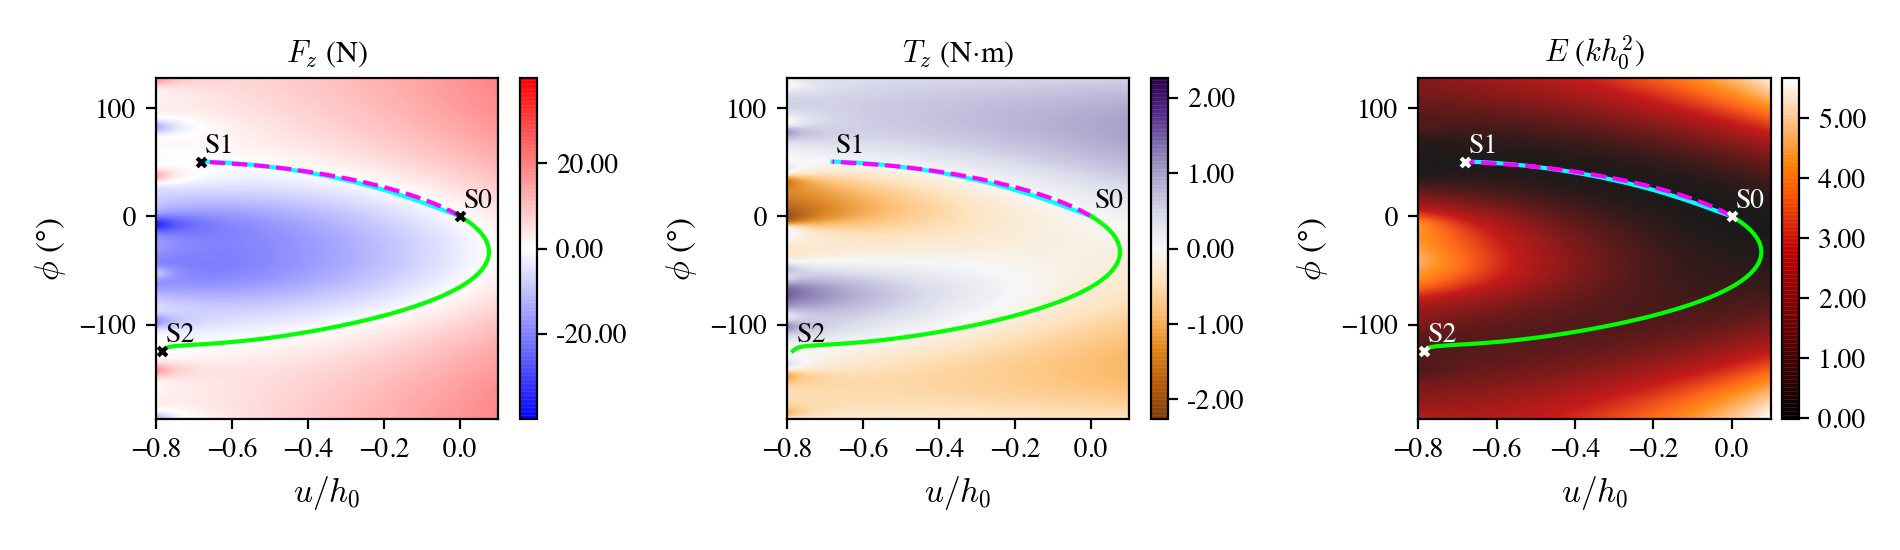

In [49]:
fig1 = plt.figure(figsize=[9.5, 2.75])

ax1 = fig1.add_subplot(131)
plt.imshow(np.flipud((Zforce_tot.T*1000)), extent=[maxdown, maxup, KT7['phi_min']*180/np.pi, KT7['phi_max']*180/np.pi],
           aspect="auto", alpha=0.9, cmap=plt.cm.bwr)
plt.colorbar(format='%.2f')
plt.clim(-np.max(np.abs(Zforce_tot*1000)),np.max(np.abs(Zforce_tot*1000)))

plt.plot(uset_tot1/h0, phi_set1*180/np.pi, '-', c='cyan', linewidth=1.5, label='path1')
plt.plot(uset_tot2/h0, phi_set2*180/np.pi, '--', c='magenta', linewidth=1.5, label='path2')
plt.plot(uset_tot3/h0, phi_set3*180/np.pi, '-', c='lime', linewidth=1.5, label='path3')
plt.scatter(pts_w[:,0], pts_w[:,1], s=10, c='k', marker='x', zorder=11)

t = ['S0', 'S1', 'S2']
for i, txt in enumerate(t):
    ax1.annotate(txt, (pts_w[i, 0]+0.01, pts_w[i, 1]+8), c='k')

ax1.set_ylabel('$\phi$ (\u00b0)', fontsize=flabel-2)
ax1.set_xlabel('$u/h_0$', fontsize=flabel-2)
ax1.set_title(f'$F_z$ (N)', fontsize=ftitle-2)
plt.xticks([-0.8, -0.6, -0.4, -0.2, 0])
plt.ylim(KT7['phi_min']*180/np.pi, KT7['phi_max']*180/np.pi)
plt.xlim(maxdown, maxup)

ax2 = fig1.add_subplot(132)
plt.imshow(np.flipud((torque_tot.T*1000)), extent=[maxdown, maxup, KT7['phi_min']*180/np.pi, KT7['phi_max']*180/np.pi], aspect="auto", 
           alpha=0.9, cmap=plt.cm.PuOr)
plt.colorbar(format='%.2f')
plt.clim(-np.max(np.abs(torque_tot*1000)),np.max(np.abs(torque_tot*1000)))

plt.plot(uset_tot1/h0, phi_set1*180/np.pi, '-', c='cyan', linewidth=1.5, label='path1')
plt.plot(uset_tot2/h0, phi_set2*180/np.pi, '--', c='magenta', linewidth=1.5, label='path2')
plt.plot(uset_tot3/h0, phi_set3*180/np.pi, '-', c='lime', linewidth=1.5, label='path3')

t = ['S0', 'S1', 'S2']
for i, txt in enumerate(t):
    ax2.annotate(txt, (pts_w[i, 0]+0.01, pts_w[i, 1]+8), c='k')

ax2.set_ylabel('$\phi$ (\u00b0)', fontsize=flabel-2)
ax2.set_xlabel('$u/h_0$', fontsize=flabel-2)
plt.xticks([-0.8, -0.6, -0.4, -0.2, 0])
ax2.set_title(f'$T_z$ (N$\cdot$m)', fontsize=ftitle-2)
plt.ylim(KT7['phi_min']*180/np.pi, KT7['phi_max']*180/np.pi)
plt.xlim(maxdown, maxup)

ax3 = fig1.add_subplot(133)
plt.imshow(np.flipud((ZZ_tot.T)), extent=[maxdown, maxup, KT7['phi_min']*180/np.pi, KT7['phi_max']*180/np.pi], aspect="auto", alpha=0.9, 
           cmap=plt.cm.gist_heat)
plt.colorbar(format='%.2f', orientation="vertical", pad = 0.025)
plt.clim(np.min(ZZ_tot), np.max(ZZ_tot))
plt.plot(uset_tot1/h0, phi_set1*180/np.pi, '-', c='cyan', linewidth=1.5, label='path1')
plt.plot(uset_tot2/h0, phi_set2*180/np.pi, '--', c='magenta', linewidth=1.5, label='path2')
plt.plot(uset_tot3/h0, phi_set3*180/np.pi, '-', c='lime', linewidth=1.5, label='path3')
plt.scatter(pts_w[:,0], pts_w[:,1], s=10, c='white', marker='x', zorder=11)

t = ['S0', 'S1', 'S2']
for i, txt in enumerate(t):
    ax3.annotate(txt, (pts_w[i, 0]+0.01, pts_w[i, 1]+8), c='white')

ax3.set_ylabel('$\phi$ (\u00b0)', fontsize=flabel-2)
ax3.set_xlabel('$u/h_0$', fontsize=flabel-2)
plt.xticks([-0.8, -0.6, -0.4, -0.2, 0])
ax3.set_title(f'$E$ ($kh_0^2$)', fontsize=ftitle-2)
plt.ylim(KT7['phi_min']*180/np.pi, KT7['phi_max']*180/np.pi)
plt.xlim(maxdown, maxup)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


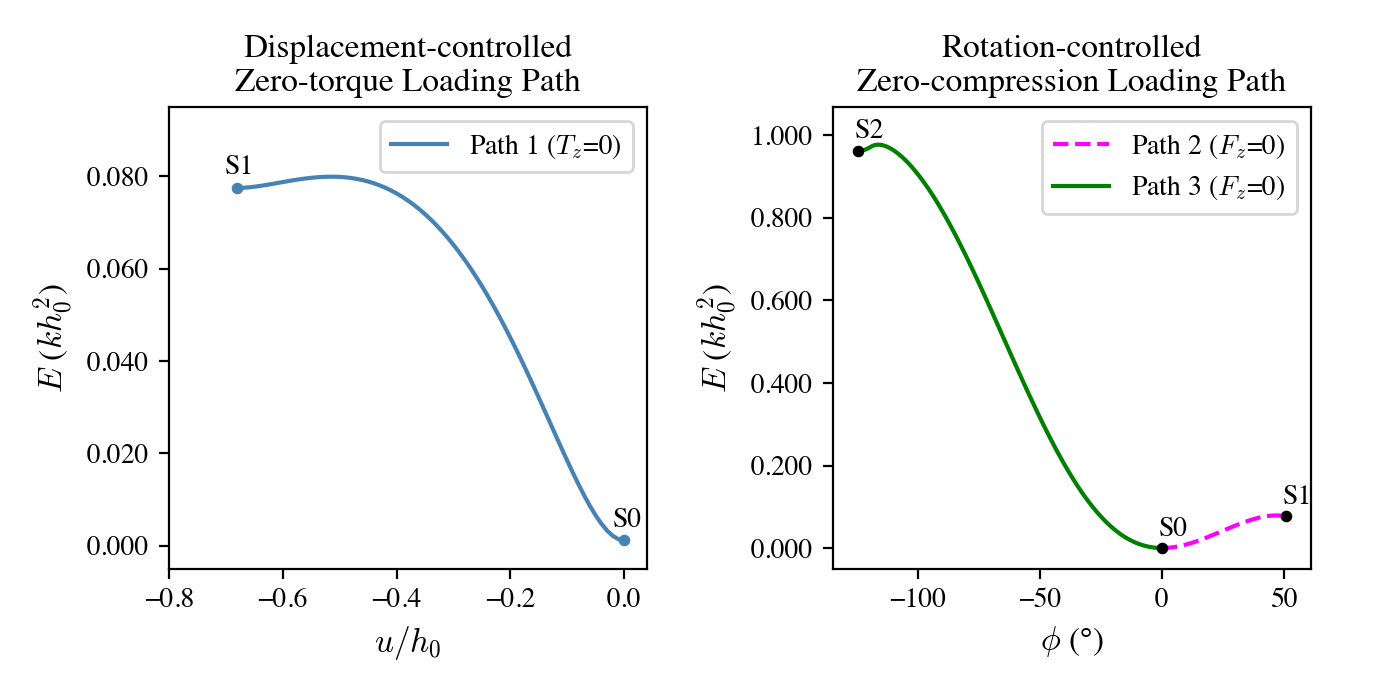

In [50]:
fig = plt.figure(figsize=[7, 3.5])

ax3= fig.add_subplot(121)
plt.plot(uset_tot1/h0, U_minset_tot1, '-', c='steelblue', linewidth=1.5, label='Path 1 ($T_z$=0)')
plt.ylabel('$E$ ($kh^2_0$)', fontsize=flabel-2)
plt.ylim(min(0, np.min(U_minset_tot1))-0.005, np.max(U_minset_tot1)+0.015)
plt.legend(loc='best')

plt.scatter(pts_w[:2,0], pts_w[:2,2], s=10, c='steelblue', zorder=11)
t = ['S0', 'S1']
for i, txt in enumerate(t):
    ax3.annotate(txt, (pts_w[i, 0]-0.02, pts_w[i, 2]+0.003), c='k')

ax3.set_xlabel('$u/h_0$' , fontsize=flabel-2)
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.xticks([-0.8, -0.6, -0.4, -0.2, 0])
plt.title(f'Displacement-controlled\nZero-torque Loading Path', fontsize=12)

ax4= fig.add_subplot(122)
plt.plot(phi_set2/np.pi*180, U_minset_tot2, '--', c='magenta', linewidth=1.5, label='Path 2 ($F_z$=0)')
plt.plot(phi_set3/np.pi*180, U_minset_tot3, '-', c='green', linewidth=1.5, label='Path 3 ($F_z$=0)')
plt.ylabel('$E$ ($kh^2_0$)', fontsize=flabel-2)
plt.ylim(np.min(U_minset_tot2)-0.05, np.max(U_minset_tot3)+0.09)
plt.legend(loc='best')
plt.scatter(pts_w[:,1], pts_w[:,2], s=10, c='k', zorder=11)

t = ['S0', 'S1', 'S2']
for i, txt in enumerate(t):
    ax4.annotate(txt, (pts_w[i, 1]-1.2, pts_w[i, 2]+0.03), c='k')

ax4.set_xlabel('$\phi$ (\u00b0)' , fontsize=flabel-2)
ax4.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.title(f'Rotation-controlled\nZero-compression Loading Path', fontsize=12)

plt.subplots_adjust(wspace=1.5)
plt.tight_layout()
plt.show()